In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
import numpy as np

In [3]:
import sys
sys.path.append(initial_path)

from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.exp_Z(1),
    n_layers = 25,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

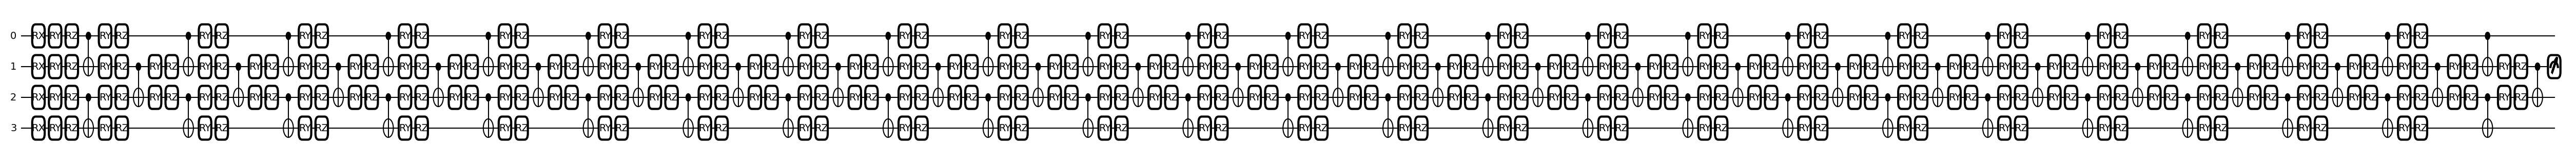

In [10]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [12]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [13]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0])]
layers += [quantum_layer()]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]

In [14]:
# Create model and set data:
model = ptm.pytorch_model(layers)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [ ]:
print(model(input_data[0]).item())
print(model(input_data[1]).item())

tensor([-0.0065], grad_fn=<CatBackward0>)

In [16]:
# train the model
model.train(
    num_epochs=2,                
    batch_size = 32,
)

Epoch [0/2], Loss: 1.0165, Loss validation: 1.0164
	 Validation string, 	 i: 0; 	 prediction: 0.2922, 	 target: 0.1608, 	 loss: 0.8172
	 Validation string, 	 i: 1; 	 prediction: 0.2919, 	 target: 0.1417, 	 loss: 1.0595
	 Validation string, 	 i: 2; 	 prediction: 0.2922, 	 target: 0.1656, 	 loss: 0.7651
Epoch [1/2], Loss: 3.6225, Loss validation: 2.2778, Time remaining: ~0.0h 2.0m 3s
	 Validation string, 	 i: 0; 	 prediction: 0.8043, 	 target: 0.1608, 	 loss: 4.0026
	 Validation string, 	 i: 1; 	 prediction: 0.8043, 	 target: 0.1417, 	 loss: 4.6752
	 Validation string, 	 i: 2; 	 prediction: 0.8043, 	 target: 0.1656, 	 loss: 3.8584
Epoch [2/2], Loss: 3.6137, Loss validation: 6.2268, Time remaining: ~0.0h 0.0m 0s


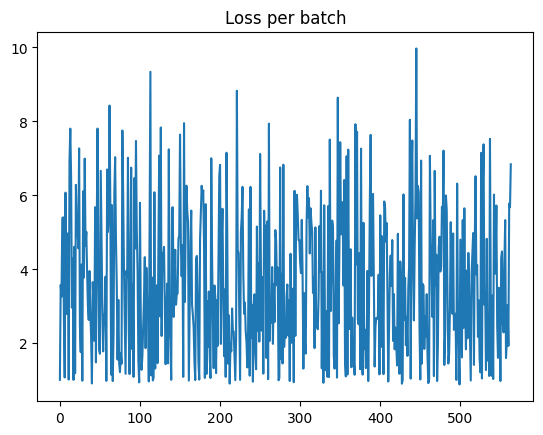

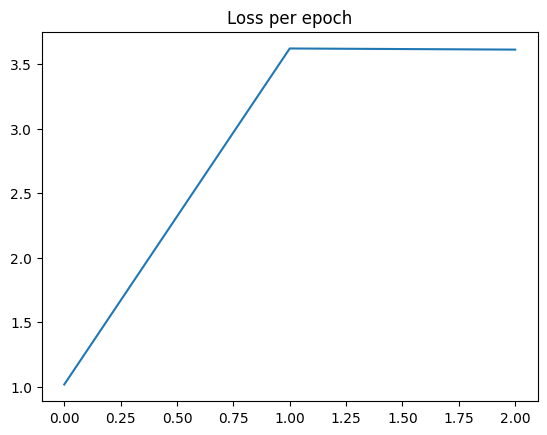

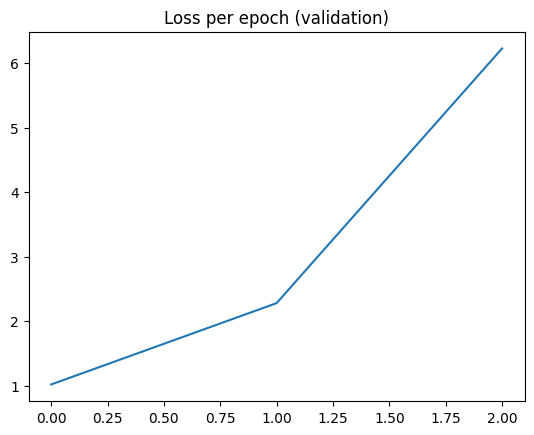

In [17]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

In [18]:
#save model
name_notebook = "0802-sh_1qm.ipynb"  

version = model.save_state_dict(name_notebook=name_notebook, initial_path=initial_path)

Model saved as ../Notebooks/models/0802/0802-sh_1qm_0.pth


In [19]:
# push changes to git
!cd peptide-QML && git add . && git commit -m "data trained model" && git push

The system cannot find the path specified.


In [20]:
#load model
model.load_state_dict(name_notebook=name_notebook, version=version, initial_path=initial_path)

Model loaded from ../Notebooks/models/0802/0802-sh_1qm_0.pth


In [21]:
# print validation
model.print_validation()

i: 0, 	 target: 0.161, 	 output: 0.804, 	 loss: 4.003
i: 1, 	 target: 0.138, 	 output: 0.804, 	 loss: 4.826
i: 2, 	 target: -0.071, 	 output: 0.804, 	 loss: 12.318
i: 3, 	 target: 0.200, 	 output: 0.804, 	 loss: 3.025
i: 4, 	 target: -0.031, 	 output: 0.804, 	 loss: 26.808
i: 5, 	 target: 0.196, 	 output: 0.804, 	 loss: 3.096
i: 6, 	 target: -0.076, 	 output: 0.804, 	 loss: 11.602
i: 7, 	 target: -0.033, 	 output: 0.804, 	 loss: 25.254
i: 8, 	 target: -0.088, 	 output: 0.804, 	 loss: 10.092
i: 9, 	 target: -0.058, 	 output: 0.804, 	 loss: 14.826
i: 10, 	 target: 0.142, 	 output: 0.804, 	 loss: 4.675
i: 11, 	 target: 0.029, 	 output: 0.804, 	 loss: 26.669
i: 12, 	 target: 0.017, 	 output: 0.804, 	 loss: 46.614
i: 13, 	 target: 0.193, 	 output: 0.804, 	 loss: 3.176
i: 14, 	 target: -0.076, 	 output: 0.804, 	 loss: 11.603
i: 15, 	 target: 0.196, 	 output: 0.804, 	 loss: 3.096
i: 16, 	 target: -0.080, 	 output: 0.804, 	 loss: 11.096
i: 17, 	 target: -0.075, 	 output: 0.804, 	 loss: 11.656


KeyboardInterrupt: 

In [40]:
import os

def check_and_create_checkpoint_folder(initial_path, day):

    folder_path = initial_path + "checkpoints/" + day

    # Check if the folder exists
    if not os.path.exists(folder_path):

        # If it doesn't exist, create it
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")

        for folder in ["models", "plots", "pdfs", "notebooks"]:
            os.makedirs(folder_path + "/" + folder)
            print(f"Folder '{folder_path}/{folder}' created successfully.")
        
    else:
        print(f"Folder '{folder_path}' already exists.")

# Path of the folder you want to check and create if it doesn't exist
day = "0802"

# Call the function to check and create the folder if necessary
check_and_create_checkpoint_folder(initial_path, day)


Folder '../checkpoints/0802' created successfully.
Folder '../checkpoints/0802/models' created successfully.
Folder '../checkpoints/0802/plots' created successfully.
Folder '../checkpoints/0802/pdfs' created successfully.
Folder '../checkpoints/0802/notebooks' created successfully.
